# **Additional Q Network training**

Below is the code for additional training of the Q-network agent. The training v.s. the greedy battle agent was so successful that we thought we could improve the final performance of the model through self-play. We use the same tricks as before: replay buffer, target network and epsilon greedy exploration. Except this time we play the network against itself (we also interleave greedy play in the replay buffer).

**Personal note:** this code is heavily inspired by the code from "Deep-Reinforcement-Learning-Hands-On-Second-Edition" by Maxim Lapan. This book helped me learn a lot about actually implementing reinforcement learning algorithms and I highly recommend it. Much of the code from this book can be found here https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On-Second-Edition .

*It is important to open drive and install gym-locm so that the AI can play games*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/locm_project
! git clone https://github.com/ronaldosvieira/gym-locm.git
%cd gym-locm
! pip install -e .

/content/drive/My Drive/locm_project
fatal: destination path 'gym-locm' already exists and is not an empty directory.
/content/drive/My Drive/locm_project/gym-locm
Obtaining file:///content/drive/My%20Drive/locm_project/gym-locm
  Running setup.py develop for gym-locm


*Imports*

In [ ]:
import numpy as np
import collections
import random
import math
import time
from operator import attrgetter
from typing import Type

import pexpect
import sys

from gym_locm.engine import *

import gym
import gym.spaces

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

*some helper code for setting up the networks*

In [ ]:
name = "LOCM-battle-v0"
env = gym.make(name)

n_actions = env.action_space.n
observation_space_shape = np.array(env.observation_space.shape).prod()

**DQN P Greedy Battle Agent** - this agent will act as our adversary for the self-play training. At the start of every game we decide to either play the rest of the game using the trained network (with frozen weights) or with the same greedy strategy as the greedy battle agent (with probability p).

In [ ]:
class DQNPGreedyBattleAgent():
  '''
  Static dqn battle agent with p greedy playout
  p = probability of playing a game with greedy strategy
  '''
  def __init__(self, p=0.5):
    self.p = p
    self.net = DQN().to(device)
    params = torch.load('../../../../drive/My Drive/training/locm-dqn-save-self2.chkpt')
    self.net.load_state_dict(params['net'])
    print('[STATIC MODEL]: Loaded trained model from locm-dqn-save-self2.chkpt')

  def seed(self, seed):
    pass

  def reset(self):
    '''
    each game randomly decide whether to play with a greedy strategy or with the trained q network
    '''
    self.greedy_policy = np.random.random() < self.p

  @staticmethod
  def eval_state(state):      
    def eval_creature(creature):
      score = 0

      if creature.attack > 0:
        score += 28.6875
        score += creature.attack * 23.375
        score += creature.defense * 29.625

        if creature.has_ability('W'):
          score += creature.attack * 26

        if creature.has_ability('L'):
          score += 29.0625

      if creature.has_ability('G'):
        score += 25.125

      return score
        
    score = 0

    pl = state.current_player
    op = state.opposing_player

    if pl.health < 5:
      score -= 100

    # check opponent's death
    if op.health <= 0:
      score += 100000

    # check own death
    elif pl.health <= 0:
      score -= 100000

    # health difference
    score += (pl.health - op.health) * 2
        
    for c in pl.hand:
      if not isinstance(c, Creature):
        score += 14.6875

    if len(pl.hand) + pl.bonus_draw + 1 <= 8:
      score += (pl.bonus_draw + 1) * 20.625
                
    for pl_lane, op_lane in zip(pl.lanes, op.lanes):
      # creature strength
      score += sum(eval_creature(c) for c in pl_lane)
      score -= sum(eval_creature(c) for c in op_lane)

    return score

  @torch.no_grad()
  def act(self, state):
    if self.greedy_policy:
      best_action, best_score = None, float("-inf")

      if len(state.available_actions) == 1:
        return state.available_actions[0]
          
      for action in state.available_actions:
        state_copy = state.clone()
        state_copy.act(action)

        score = self.eval_state(state_copy)
        if score > best_score:
          best_action, best_score = action, score
      return best_action
    else:
      # q network action
      state = env.encode_state()

      indices = torch.tensor(available_actions()).to(device)
      mask = torch.zeros(n_actions, dtype=torch.bool).to(device)
      mask.scatter_(0, indices, True)

      state_a = np.array([state], copy=False)
      state_v = torch.tensor(state_a).to(device)

      q_vals_v = self.net(state_v, mask).cpu()
      act_v = q_vals_v.argmax()
      action = int(act_v.item())

      return action

# **Main training code**

In [ ]:
def available_actions():
  available_actions = env.state.available_actions
  action_numbers = []

  for action_number in range(n_actions):
    action = env.decode_action(action_number)
    if action in available_actions:
      action_numbers.append(action_number)

  return np.array(action_numbers, dtype=np.int64)

class DQN(nn.Module):
  def __init__(self):
    super(DQN, self).__init__()

    self.fc = nn.Sequential(
        nn.Linear(observation_space_shape, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, n_actions)
    )
  
  def forward(self, x, mask):
    x = x.view(x.size(0),-1)
    fx = x.float() / 256
    q_vals_v = self.fc(fx)

    masked_q_vals_v = q_vals_v.masked_fill(~mask, -np.inf)
    return masked_q_vals_v

Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'mask', 'reward', 'done', 'new_state', 'new_mask'])

class ReplayBuffer():
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, batch_size):
      indices = np.random.choice(self.size(), batch_size, replace=False)

      states, actions, masks, rewards, dones, next_states, next_masks = zip(*[self.buffer[idx] for idx in indices])
      return np.array(states), np.array(actions, dtype=np.int64), np.array(masks, dtype=np.bool), np.array(rewards, dtype=np.float32), np.array(dones, dtype=np.uint8), np.array(next_states), np.array(next_masks, dtype=np.bool)
   
    def size(self):
        return len(self.buffer)

def calc_loss(batch, net, tgt_net, device="cpu"):
  states, actions, masks, rewards, dones, next_states, next_masks = batch

  # wrap np array in tensors
  states_v = torch.tensor(np.array(states, copy=False)).to(device)
  next_states_v = torch.tensor(np.array(next_states, copy=False)).to(device)
  actions_v = torch.tensor(actions).to(device)
  masks_v = torch.tensor(masks).to(device)
  rewards_v = torch.tensor(rewards).to(device)
  done_mask = torch.BoolTensor(dones).to(device)
  next_masks_v = torch.tensor(next_masks).to(device)
  
  # pass observations to the network and get Q values
  state_action_values = net(states_v, masks_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
  
  with torch.no_grad():
    # use the target network to the next state obseravtion and get the maximum q value for the same action
      next_state_values = tgt_net(next_states_v, next_masks_v).max(1)[0]
      next_state_values[done_mask] = 0.0
      next_state_values = next_state_values.detach()

  # calculate bellman approximation and MSE loss
  expected_state_action_values = next_state_values * GAMMA + rewards_v
  #print(state_action_values, next_state_values)
  return nn.MSELoss()(state_action_values, expected_state_action_values)

class Agent:
  def __init__(self, replay_buffer):
    self.replay_buffer = replay_buffer
    self._reset()

  def _reset(self):
    self.state = env.reset()

  @torch.no_grad()
  def play_step(self, net, epsilon, device="cpu"):
    final_reward = None

    indices = torch.tensor(available_actions()).to(device)
    mask = torch.zeros(n_actions, dtype=torch.bool).to(device)
    mask.scatter_(0, indices, True)
      
    if np.random.random() < epsilon:
      action = np.random.choice(available_actions())
    else:
      state_a = np.array([self.state], copy=False)
      state_v = torch.tensor(state_a).to(device)

      q_vals_v = net(state_v, mask).cpu()
      act_v = q_vals_v.argmax()
      action = int(act_v.item())
    
    new_state, reward, done, info = env.step(action)

    indices = torch.tensor(available_actions())
    new_mask = torch.zeros(n_actions, dtype=torch.bool)
    new_mask.scatter_(0, indices, True)

    if new_state is None:
      new_state = np.zeros((observation_space_shape,), dtype=np.float32)

    mask = mask.cpu().numpy()
    new_mask = new_mask.cpu().numpy()

    replay = Experience(self.state, action, mask, reward, done, new_state, new_mask)
    self.replay_buffer.put(replay)
    self.state = new_state

    if done:
      final_reward = reward
      self._reset()
      
    return final_reward

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 200000
REPLAY_START_SIZE = 40000
LEARNING_RATE = 5e-5
SYNC_TARGET_FRAMES = 1000

EPSILON_DECAY_LAST_FRAME = 2000000
EPSILON_START = 0.20
EPSILON_FINAL = 0.01

epsilon = EPSILON_START

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

name = "LOCM-battle-v0"
env = gym.make(name, battle_agent=DQNPGreedyBattleAgent())

best_m_reward = 0.0
n_episode = 0
rewards = []
losses = []
m_rewards = []
m_losses = []

seed = 742
torch.manual_seed(seed)
env.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

net = DQN().to(device)
target_net = DQN().to(device)
#target_net.load_state_dict(net.state_dict())
memory = ReplayBuffer(REPLAY_SIZE)

print(net)

agent = Agent(memory)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

frame_idx = 0

params = torch.load('../../../../drive/My Drive/training/locm-dqn-save-self2.chkpt')
net.load_state_dict(params['net'])
target_net.load_state_dict(net.state_dict())
optimizer.load_state_dict(params['optimizer'])
print("[TRAINABLE MODEL]: Loaded trained model from locm-dqn-save-self2.chkpt")

ts_frame = frame_idx
ts = time.time()

while True:
  frame_idx += 1
  epsilon = max(EPSILON_FINAL, EPSILON_START - (frame_idx / EPSILON_DECAY_LAST_FRAME) * EPSILON_START)
  reward = agent.play_step(net, epsilon, device=device)
  
  if reward is not None:
    n_episode += 1
    
    if reward == 1:
      rewards.append(1)
    else:
      rewards.append(0)

    if frame_idx > REPLAY_START_SIZE and n_episode%100==0:
      speed = (frame_idx - ts_frame) / (time.time() - ts)
      ts_frame = frame_idx
      ts = time.time()

      m_reward = np.mean(rewards[-100:])
      m_loss = np.mean(losses[-100:])

      m_rewards.append(m_reward)
      m_losses.append(m_loss)

      if best_m_reward < m_reward:
        print("NEW BEST MEAN REWARD --> {:.2f}% win rate".format(m_reward*100))
        best_m_reward = m_reward
      
      print("frame: {},  episode: {}, win rate: {:.1f}%, epsilon: {:.3f}, loss: {:.4f}, f/s: {:.2f}".format(
            frame_idx, n_episode, m_reward*100, epsilon, m_loss, speed
      ))

      torch.save({'net':net.state_dict(), 'optimizer':optimizer.state_dict()}, '../../../../drive/My Drive/training/locm-dqn-save-self3.chkpt')
        
      losses.clear()
      rewards.clear()

  if memory.size()<REPLAY_START_SIZE:
    continue

  optimizer.zero_grad()
  batch = memory.sample(BATCH_SIZE)
  loss_t = calc_loss(batch, net, target_net, device=device)
  loss_t.backward()
  optimizer.step()
  losses.append(loss_t.item())

  if frame_idx%SYNC_TARGET_FRAMES == 0:
    target_net.load_state_dict(net.state_dict())

*Let's display the win rate and loss during training*

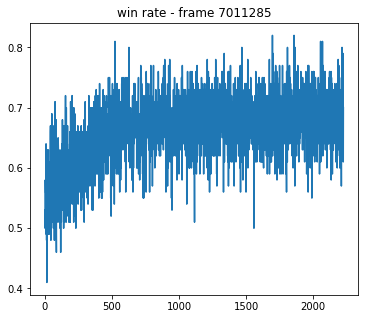

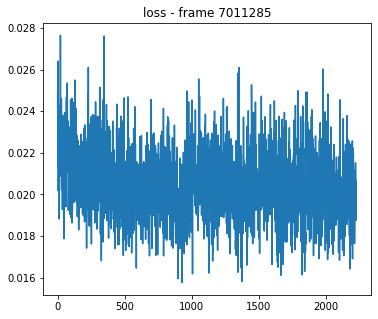

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('win rate - frame {}'.format(frame_idx))
plt.plot(m_rewards)
plt.show()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('loss - frame {}'.format(frame_idx))
plt.plot(m_losses)
plt.show()